In [213]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from trajectories import TrajectoriesDataset, preprocess_dataset, find_activations
from torch.utils.data import DataLoader
import os


In [230]:
seed = 42
batch_size = 128
data_path = 'trajectories/ep15000_dur36.20_ret0.52/trajectories/10.00K.pt'

device = torch.device('cuda')

dataset = torch.load(data_path)
trigger_activations = find_activations(dataset.observations, dataset.actions, target='trigger').to(device)
trigger_activations_indices = torch.argmax(trigger_activations, axis=-1).to(device) # indices of steps when action to take the trigger was taken 
prize_activations = find_activations(dataset.observations, dataset.actions, target='prize')
prize_activations_indices = torch.argmax(prize_activations, axis=-1) # indices of steps when action to take the prize was taken 
episodes_with_prize_mask = torch.sum(prize_activations, axis=-1).to(device) # mask for episodes where prizes were taken

train_loader, valid_loader = preprocess_dataset(dataset, data_path, sum_rewards=False, normalize=False)


weights tensor([[ 0.0000, 14.3684, 25.5322, 37.1309, 43.7681, 34.8773, 22.7974, 17.3332,
          0.0000],
        [ 0.0000, 12.6842, 26.4412, 38.7883, 52.3513, 34.5784, 22.9849,  8.4612,
          0.0000]])
weights averaged tensor([ 0.0000, 13.5263, 25.9867, 37.9596, 48.0597, 34.7279, 22.8912, 12.8972,
         0.0000])


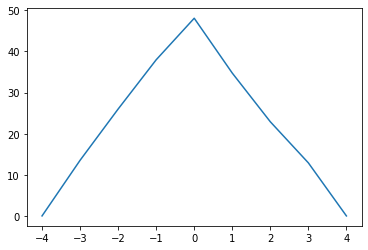

In [222]:
batch_size = 2

seq_len = dataset.observations.shape[1]
attention_weights_global = torch.zeros((batch_size, seq_len*2+1)) # N, S*2



values = torch.rand((batch_size, seq_len)) # N, S
trigger_positions = torch.randint(0, seq_len, (batch_size,)) # N

indices = torch.arange(0, seq_len) + seq_len
indices = indices.repeat(batch_size, 1)
indices -= trigger_positions[:, None]

added_values = torch.zeros_like(attention_weights_global)
attention_weights_global += added_values.scatter(1, indices, values)

print('weights', attention_weights_global)

weights_averaged = torch.sum(attention_weights_global, axis=0) / batch_size
print('weights averaged', weights_averaged)

x_axis = np.arange(weights_averaged.shape[0]) - seq_len
plt.plot(x_axis, weights_averaged)





att indices cuda:0
attention_discrete torch.Size([128, 50])
ground truth tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0], device='cuda:0', dtype=torch.uint8)
credit assignment tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0], device='cuda:0', dtype=torch.uint8)
precision: tensor(0.2500, device='cuda:0')
recall: tensor(0.1429, device='cuda:0')
tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
    

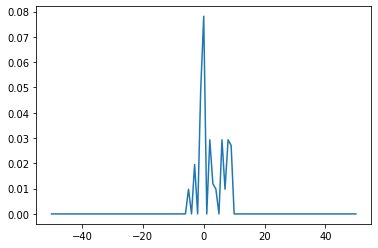

In [242]:

from reward_predictor import RewardPredictor
from train_reward_predictor import PAD_VAL, ACTION_SPACE_SIZE, OBSERVATION_SPACE_DIMS

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RewardPredictor(OBSERVATION_SPACE_DIMS, ACTION_SPACE_SIZE, device, verbose=False).to(device)

ATTENTION_THRESHOLD = 0.2

seq_len = dataset.observations.shape[1]
attention_weights_global = torch.zeros((batch_size, seq_len*2+1), device=device) # N, S*2

for i, batch in enumerate(train_loader):
    observations, actions, returns, indices = batch

    N, _, _ = actions.shape

    trigger_activations_batch = trigger_activations[indices] # credit assignment ground truth
    trigger_activations_indices_batch = trigger_activations_indices[indices]
    prize_activations_batch = prize_activations_indices[indices] # moments at which we want to evaluate attention
    prize_episodes_mask_batch = episodes_with_prize_mask[indices] # mask to zero out attention in episodes without touching prize

    # print('triggers', torch.argmax(trigger_activations_batch, axis=-1).shape)
    # print('episodes mask:', episodes_with_prize_mask_batch.shape)

    observations = observations.transpose(
                    2, 4).transpose(0, 1).to(device)
    actions = actions.transpose(0, 1).to(device)
    returns = returns.transpose(0, 1).to(device)

    _, attention_matrices = model(observations, actions, output_attention=True) # (N, L, S) where `L` - reward sequence, `S` - inputs sequence

    # for some weird reason, attention_matrices[:, prize_activations_batch] results in [N, N, S] rather than [N, S]
    # fixed with help of: https://discuss.pytorch.org/t/selecting-element-on-dimension-from-list-of-indexes/36319/2?u=nick-baliesnyi
    attention_vals = attention_matrices[torch.arange(N), prize_activations_batch]
    attention_vals *= prize_episodes_mask_batch[:, None] # zero out episodes where prize wasn't touched

    episode = 3
    
    attention_discrete = torch.gt(attention_vals, ATTENTION_THRESHOLD, out=torch.empty(attention_vals.shape, dtype=torch.uint8, device=device))

    attention_indices = torch.arange(0, seq_len) + seq_len
    attention_indices = attention_indices.repeat(batch_size, 1).to(device)
    print('att indices', attention_indices.device)
    attention_indices -= trigger_activations_indices_batch[:, None]

    added_values = torch.zeros_like(attention_weights_global)
    attention_weights_global += added_values.scatter(1, attention_indices, attention_vals)

    print('attention_discrete', attention_discrete.shape)
    print('ground truth', trigger_activations_batch[episode])
    print('credit assignment', attention_discrete[episode])

    # TODO: padding mask
    true_positives = torch.sum(torch.logical_and(attention_discrete, trigger_activations_batch))
    precision = true_positives / torch.sum(attention_discrete)
    recall = true_positives / torch.sum(trigger_activations_batch)

    print('precision:', precision)
    print('recall:', recall)

    weights_averaged = torch.sum(attention_weights_global, axis=0) / batch_size
    x_axis = torch.arange(weights_averaged.shape[0]) - seq_len
    plt.plot(x_axis.cpu(), weights_averaged.cpu())
    print(weights_averaged)

    # if log:
    #    weights_averaged = torch.sum(attention_weights_global, axis=0) / batch_size # / log_frequency
    #    attention_weights_global *= 0
    #    x_axis = torch.arange(weights_averaged.shape[0]) - seq_len
    #    plt.plot(x_axis.cpu(), weights_averaged.cpu())
    #    wandb.log('chart', plt)

    # episode = 3
    # attn = attention_at_prize_activations[episode].detach().cpu().numpy()
    # plt.plot(attn)

    break

    

In [84]:
train_loader.dataset.dataset.observations

torch.Size([10000, 50, 24, 24, 3])

unique: tensor([1, 2])
red tensor([255,  76,  76], dtype=torch.uint8)
pink tensor([255,  76, 249], dtype=torch.uint8)


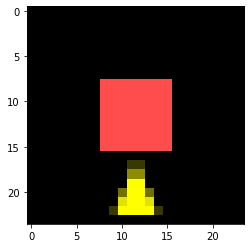

In [51]:
# debug
loader = DataLoader(dataset_new, batch_size=128)
episode = 3

for i, batch in enumerate(loader):
    observations, actions, reward, indices = batch

    # observations = observations.type(torch.FloatTensor)
    # observations[observations == 10] = 0

    # mean = torch.mean(observations, axis=(0,1,2,3))
    # std = torch.std(observations, axis=(0,1,2,3))
    # observations = (observations - mean) / std

    returns = torch.ones_like(reward) * 0
    sums = torch.sum(reward, axis=1)

    returns += sums[:, None]
    returns += 1
    print('unique:', torch.unique(returns))
    renormalized = (observations * std + mean).type(torch.ByteTensor)
    plt.imshow(renormalized[episode, 3, :, :, :])
    print('red',renormalized[episode, 3, 12, 12, :])
    print('pink',renormalized[episode, 7, 12, 12, :])
    plt.show()
    break